<a href="https://colab.research.google.com/github/yuji-sgs/web-optimization/blob/main/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2章: 確率的プログラミング: コンピュータの助けを借りる

In [2]:
!pip install -U arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [1]:
# 必要なモジュールの読み込み
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

<ipython-input-1-89b4c6d4cdb1>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 統計モデルの記述とサンプリングの実行

In [3]:
N = 40  # アリスのデザインA案の表示数
a = 2   # アリスのデザインA案のクリック数

with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1)
  # theta = pm.Beta('theta', alpha=1, beta=1)
  obs = pm.Binomial('a', p=theta, n=N, observed=a)
  trace = pm.sample(5000, chains=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba = importlib.import_module("numba")


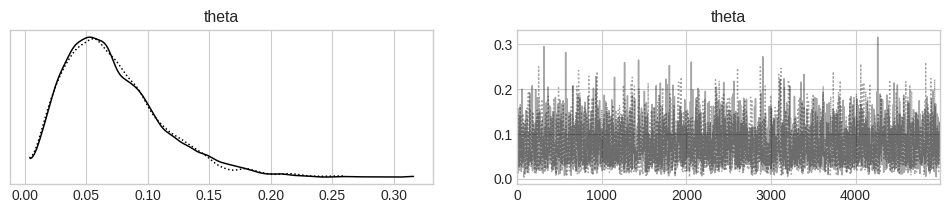

In [4]:
# 事後分布からのサンプルの可視化
with model:
  pm.plot_trace(trace)

In [5]:
with model:
  print(pm.summary(trace, hdi_prob=0.95))

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba = importlib.import_module("numba")


        mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.072  0.04      0.01       0.15      0.001      0.0    3654.0   

       ess_tail  r_hat  
theta    4156.0    1.0  


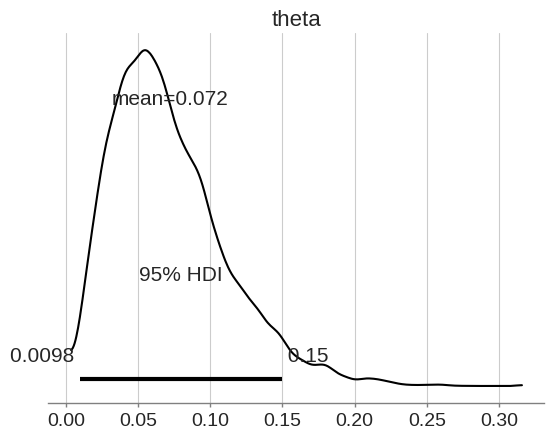

In [6]:
with model:
  pm.plot_posterior(trace, hdi_prob=0.95)

In [7]:
# 仮説：アリスのデザインA案のクリック率は1％以上である。
# 定量的評価：新たな確率変数𝛿=θ-0.01のサンプルが95%の確率で正になる。
theta_samples = trace.posterior['theta'].values.flatten()
print((theta_samples - 0.01 > 0).mean())

0.9933


### アリスのデザイン案AおよびBのクリック率のサンプルの可視化

In [21]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[40, 50], observed=[2, 4])
  trace = pm.sample(5000, chains=2)

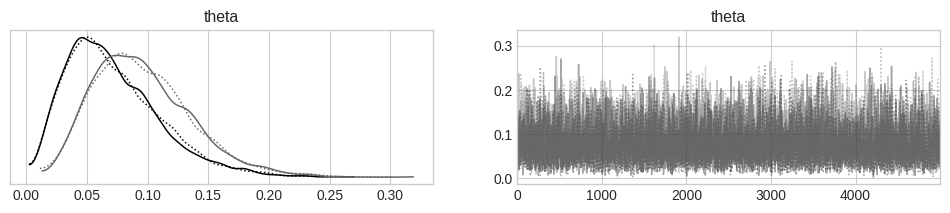

In [22]:
with model:
  pm.plot_trace(trace, ['theta'], compact=True)

In [23]:
# 仮説：B案のクリック率はA案よりも大きい
# 定量的評価：新たな確率変数𝛿=θB-θAのサンプルが95%の確率で正の値になる
theta_A = trace.posterior['theta'].sel(theta_dim_0=0).values.flatten()
theta_B = trace.posterior['theta'].sel(theta_dim_0=1).values.flatten()
print((theta_B - theta_A > 0).mean())

0.6758


### ボブのデザイン案AおよびBのクリック率のサンプルの可視化

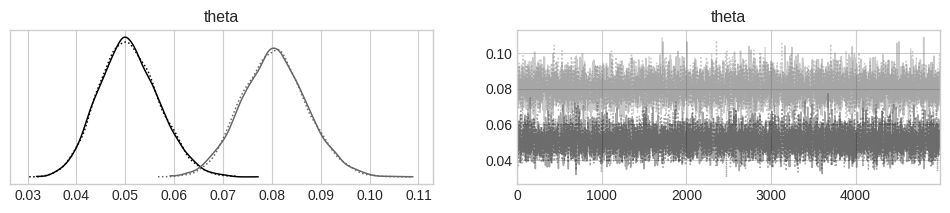

In [24]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[1280, 1600], observed=[64, 128])
  trace = pm.sample(5000, chains=2)
  pm.plot_trace(trace, ['theta'], compact=True)

In [25]:
# 仮説：B案のクリック率はA案よりも大きい
# 定量的評価：新たな確率変数𝛿=θB-θAのサンプルが95%の確率で正の値になる
theta_A = trace.posterior['theta'].sel(theta_dim_0=0).values.flatten()
theta_B = trace.posterior['theta'].sel(theta_dim_0=1).values.flatten()
print((theta_B - theta_A > 0).mean())

0.9997
